Membuat satu contoh data dan memvisualisasikannya...


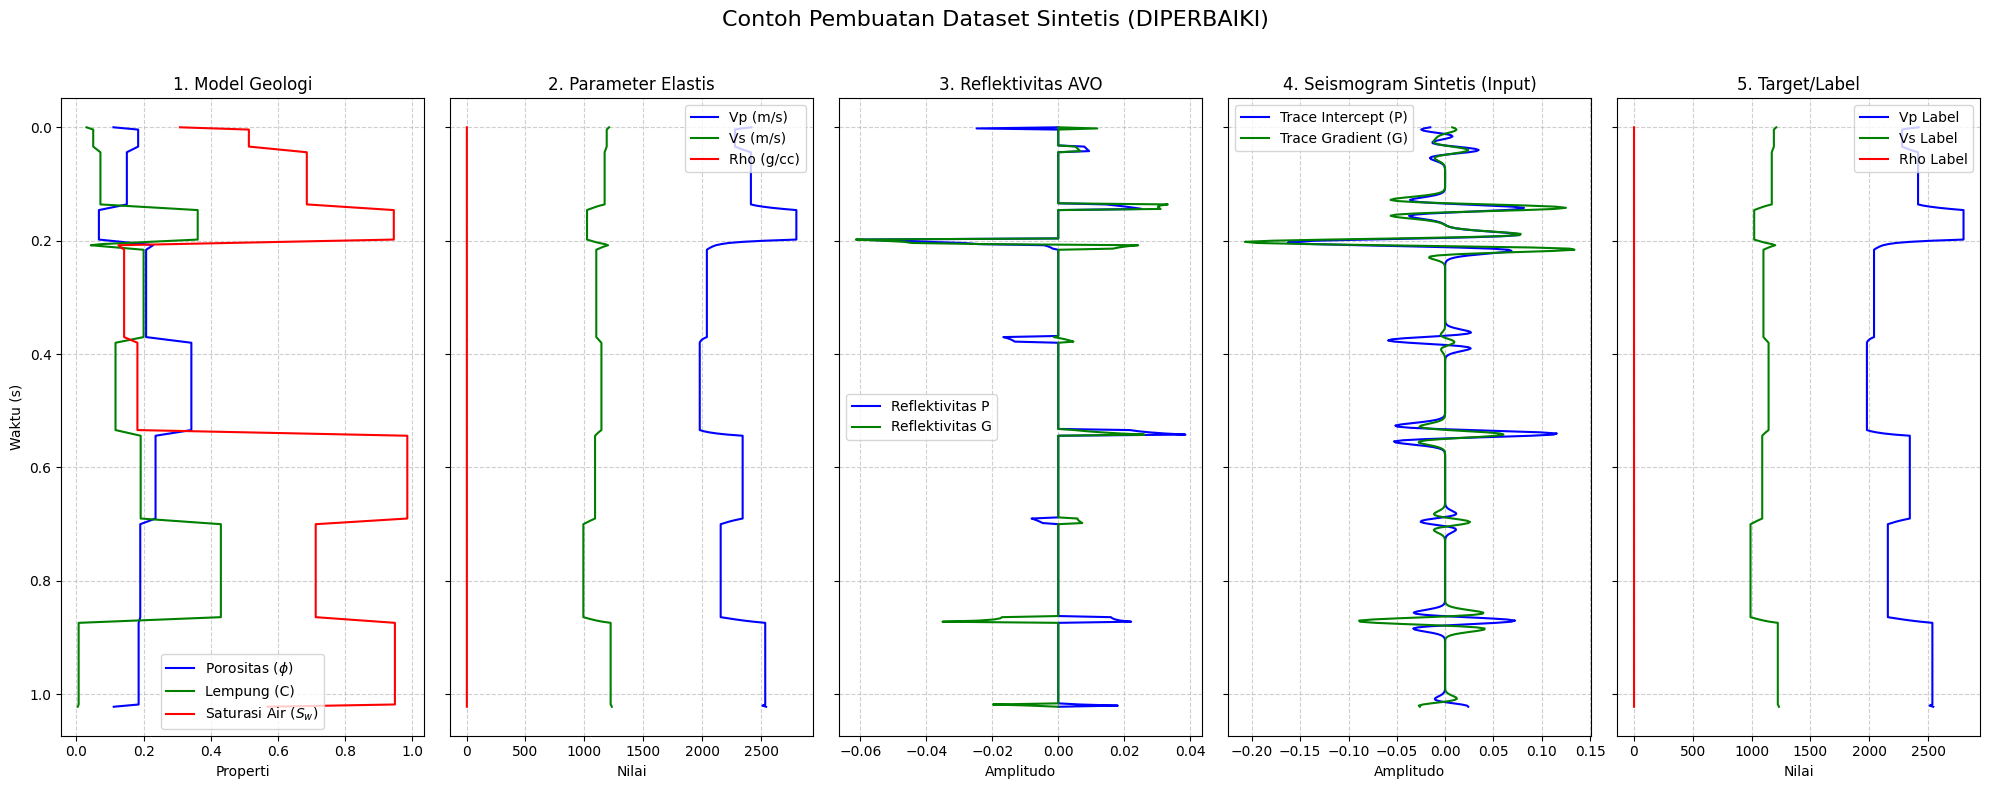

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# LANGKAH 1: DEFINISIKAN KONSTANTA FISIKA BATUAN (PERBAIKAN SATUAN)
# =============================================================================
# Properti mineral (Kuarsa dan Lempung)
K_q, G_q = 36.6, 45.0  # Modulus Bulk & Geser Kuarsa (GPa)
rho_q = 2.65           # Densitas Kuarsa (g/cc)
K_c, G_c = 21.0, 7.0   # Modulus Bulk & Geser Lempung (GPa)
rho_c = 2.58           # Densitas Lempung (g/cc)

# Properti fluida (Air dan Minyak)
K_w, rho_w = 2.25, 1.0  # Modulus Bulk & Densitas Air (GPa, g/cc)
K_o, rho_o = 0.9, 0.7   # Modulus Bulk & Densitas Minyak (GPa, g/cc)

# Parameter lainnya
coord_num = 9           # Coordination number untuk model Hertz-Mindlin
pressure = 0.02         # Tekanan efektif (GPa) - DIKONVERSI DARI MPa
f_wavelet = 30          # Frekuensi dominan Ricker wavelet (Hz)
dt = 0.002              # Sampling interval waktu (s)

# =============================================================================
# LANGKAH 2: FUNGSI-FUNGSI PEMBANTU (DIPERBAIKI)
# =============================================================================

def create_geological_model(n_samples=512, n_layers=10, smooth_window=5):
    """Membuat model geologi 1D (log) yang halus untuk porositas, lempung, dan saturasi air."""
    t = np.arange(0, n_samples * dt, dt)
    phi = np.zeros(n_samples)
    clay = np.zeros(n_samples)
    sw = np.zeros(n_samples)
    
    layer_boundaries = np.sort(np.random.randint(0, n_samples, n_layers - 1))
    layer_boundaries = np.concatenate(([0], layer_boundaries, [n_samples]))
    
    for i in range(n_layers):
        start, end = layer_boundaries[i], layer_boundaries[i+1]
        phi[start:end] = np.random.uniform(0.05, 0.35)
        clay[start:end] = np.random.uniform(0.0, 0.5)
        sw[start:end] = np.random.uniform(0.1, 1.0)
        
    # Menghaluskan model 'blocky'
    smoothing_filter = np.ones(smooth_window) / smooth_window
    phi_smooth = np.convolve(phi, smoothing_filter, mode='same')
    clay_smooth = np.convolve(clay, smoothing_filter, mode='same')
    sw_smooth = np.convolve(sw, smoothing_filter, mode='same')
    
    # Clipping nilai agar dalam rentang fisik
    phi_smooth = np.clip(phi_smooth, 0.05, 0.35)
    clay_smooth = np.clip(clay_smooth, 0.0, 0.5)
    sw_smooth = np.clip(sw_smooth, 0.1, 1.0)
    
    return phi_smooth, clay_smooth, sw_smooth, t

def rock_physics_model(phi, clay, sw):
    """Mengkonversi properti geologi ke parameter elastis menggunakan model fisika batuan (DIPERBAIKI)."""
    n = len(phi)
    vp = np.zeros(n)
    vs = np.zeros(n)
    rho_sat = np.zeros(n)
    
    for i in range(n):
        # 1. Fraksi mineral
        f_c = clay[i]
        f_q = 1 - f_c
        
        # 2. Modulus Matriks (Hill Average)
        K_voigt = f_q * K_q + f_c * K_c
        K_reuss = 1 / (f_q/K_q + f_c/K_c)
        K_m = (K_voigt + K_reuss) / 2
        
        G_voigt = f_q * G_q + f_c * G_c
        G_reuss = 1 / (f_q/G_q + f_c/G_c)
        G_m = (G_voigt + G_reuss) / 2
        
        rho_m = f_q * rho_q + f_c * rho_c
        
        # 3. Modulus Fluida (Rata-rata Reuss)
        K_fl = 1 / (sw[i] / K_w + (1 - sw[i]) / K_o)
        rho_fl = sw[i] * rho_w + (1 - sw[i]) * rho_o
        
        # 4. Rasio Poisson Matriks
        denom = 2 * (3*K_m + G_m)
        if denom > 0:
            nu_m = (3*K_m - 2*G_m) / denom
        else:
            nu_m = 0.25  # Default value
        
        # 5. Modulus Batuan Kering (Hertz-Mindlin)
        common_term = (coord_num**2 * (1-phi[i])**2 * G_m**2 * pressure) / (18 * np.pi**2 * (1 - nu_m)**2)
        K_HM = common_term**(1/3)
        
        common_term_g = (3 * coord_num**2 * (1-phi[i])**2 * G_m**2 * pressure) / (2 * np.pi**2 * (1 - nu_m)**2)
        G_HM = (common_term_g**(1/3)) * (5-4*nu_m)/(5*(2-nu_m))
        
        # 6. Substitusi Fluida (Gassmann)
        term = (1 - K_HM/K_m)**2
        denominator = phi[i]/K_fl + (1-phi[i])/K_m - K_HM/(K_m**2)
        
        # Penanganan nilai denominator tidak valid
        if denominator <= 0:
            K_sat = K_HM  # Fallback to dry rock modulus
        else:
            K_sat = K_HM + term / denominator
            
        G_sat = G_HM
        
        # 7. Densitas Saturasi
        rho_sat[i] = rho_m * (1 - phi[i]) + rho_fl * phi[i]
        
        # 8. Kecepatan Gelombang (DIPERBAIKI SATUAN)
        # Konversi ke Pa dan kg/m3
        K_sat_pa = K_sat * 1e9
        G_sat_pa = G_sat * 1e9
        rho_sat_kgm3 = rho_sat[i] * 1000
        
        vp[i] = np.sqrt((K_sat_pa + 4/3 * G_sat_pa) / rho_sat_kgm3)
        vs[i] = np.sqrt(G_sat_pa / rho_sat_kgm3)
    
    return vp, vs, rho_sat

def calculate_avo_reflectivity(vp, vs, rho):
    """Menghitung reflektivitas Intercept (P) dan Gradient (G) dari log elastis (DIPERBAIKI STABILITAS)."""
    n_samples = len(vp)
    rc_p = np.zeros(n_samples)
    rc_g = np.zeros(n_samples)
    
    for i in range(1, n_samples-1):  # Hindari boundary issues
        # Rata-rata aritmetik
        vp_avg = (vp[i+1] + vp[i]) / 2
        vs_avg = (vs[i+1] + vs[i]) / 2
        rho_avg = (rho[i+1] + rho[i]) / 2
        
        # Perbedaan
        delta_vp = vp[i+1] - vp[i]
        delta_vs = vs[i+1] - vs[i]
        delta_rho = rho[i+1] - rho[i]
        
        # Penanganan pembagian nol
        if vp_avg <= 0 or rho_avg <= 0 or vs_avg <= 0:
            rc_p[i] = 0
            rc_g[i] = 0
            continue
            
        # Aproksimasi Aki-Richards 2-term
        rc_p[i] = 0.5 * (delta_vp / vp_avg + delta_rho / rho_avg)
        rc_g[i] = 0.5 * (delta_vp / vp_avg) - 2 * (vs_avg**2 / vp_avg**2) * (2 * delta_vs / vs_avg + delta_rho / rho_avg)
        
    return rc_p, rc_g

def create_ricker_wavelet(f, dt, length=0.128):
    """Membuat Ricker wavelet (TETAP)."""
    t = np.arange(-length/2, (length/2), dt)
    t2 = t**2
    f2 = f**2
    y = (1 - 2 * np.pi**2 * f2 * t2) * np.exp(-np.pi**2 * f2 * t2)
    return y

def generate_synthetic_seismic(rc_p, rc_g, wavelet):
    """Melakukan konvolusi untuk menghasilkan seismogram sintetis (TETAP)."""
    seis_p = np.convolve(rc_p, wavelet, mode='same')
    seis_g = np.convolve(rc_g, wavelet, mode='same')
    return seis_p, seis_g

# =============================================================================
# LANGKAH 3: GABUNGKAN SEMUA UNTUK MEMBUAT SATU CONTOH DATASET (DIPERBAIKI)
# =============================================================================

def generate_one_sample(plot=False):
    """Fungsi utama untuk menghasilkan satu pasang data (input, label)."""
    # 1. Buat model geologi
    phi, clay, sw, t = create_geological_model()
    
    # 2. Hitung parameter elastis
    vp, vs, rho = rock_physics_model(phi, clay, sw)
    
    # 3. Hitung reflektivitas AVO
    rc_p, rc_g = calculate_avo_reflectivity(vp, vs, rho)
    
    # 4. Buat wavelet dan seismogram
    wavelet = create_ricker_wavelet(f_wavelet, dt)
    seis_p, seis_g = generate_synthetic_seismic(rc_p, rc_g, wavelet)
    
    # Gabungkan input dan label
    input_seismic = np.stack([seis_p, seis_g], axis=-1)  # Shape: (n_samples, 2)
    label_logs = np.stack([vp, vs, rho], axis=-1)       # Shape: (n_samples, 3)
    
    if plot:
        # Visualisasi hasil
        fig, axs = plt.subplots(1, 5, figsize=(20, 8), sharey=True)
        fig.suptitle('Contoh Pembuatan Dataset Sintetis (DIPERBAIKI)', fontsize=16)

        # Plot 1: Model Geologi
        axs[0].plot(phi, t, 'b-', label='Porositas ($\phi$)')
        axs[0].plot(clay, t, 'g-', label='Lempung (C)')
        axs[0].plot(sw, t, 'r-', label='Saturasi Air ($S_w$)')
        axs[0].set_title('1. Model Geologi')
        axs[0].set_xlabel('Properti')
        axs[0].set_ylabel('Waktu (s)')
        axs[0].legend()
        axs[0].grid(True, linestyle='--', alpha=0.6)
        axs[0].invert_yaxis()

        # Plot 2: Parameter Elastis
        axs[1].plot(vp, t, 'b-', label='Vp (m/s)')
        axs[1].plot(vs, t, 'g-', label='Vs (m/s)')
        axs[1].plot(rho, t, 'r-', label='Rho (g/cc)')
        axs[1].set_title('2. Parameter Elastis')
        axs[1].set_xlabel('Nilai')
        axs[1].legend()
        axs[1].grid(True, linestyle='--', alpha=0.6)

        # Plot 3: Reflektivitas AVO
        axs[2].plot(rc_p, t, 'b-', label='Reflektivitas P')
        axs[2].plot(rc_g, t, 'g-', label='Reflektivitas G')
        axs[2].set_title('3. Reflektivitas AVO')
        axs[2].set_xlabel('Amplitudo')
        axs[2].legend()
        axs[2].grid(True, linestyle='--', alpha=0.6)

        # Plot 4: Seismogram Sintetis
        axs[3].plot(seis_p, t, 'b-', label='Trace Intercept (P)')
        axs[3].plot(seis_g, t, 'g-', label='Trace Gradient (G)')
        axs[3].set_title('4. Seismogram Sintetis (Input)')
        axs[3].set_xlabel('Amplitudo')
        axs[3].legend()
        axs[3].grid(True, linestyle='--', alpha=0.6)

        # Plot 5: Target/Label
        axs[4].plot(label_logs[:,0], t, 'b-', label='Vp Label')
        axs[4].plot(label_logs[:,1], t, 'g-', label='Vs Label')
        axs[4].plot(label_logs[:,2], t, 'r-', label='Rho Label')
        axs[4].set_title('5. Target/Label')
        axs[4].set_xlabel('Nilai')
        axs[4].legend()
        axs[4].grid(True, linestyle='--', alpha=0.6)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    return input_seismic, label_logs

# =============================================================================
# LANGKAH 4: BUAT DATASET LENGKAP DAN SIMPAN (TETAP)
# =============================================================================

def create_and_save_dataset(num_of_models=1000, filename_prefix='synthetic_avo_dataset'):
    """Membuat dataset dengan banyak model dan menyimpannya ke file."""
    
    all_inputs = []
    all_labels = []
    
    print(f"Membuat {num_of_models} model sintetis...")
    
    for i in range(num_of_models):
        input_data, label_data = generate_one_sample(plot=False)
        all_inputs.append(input_data)
        all_labels.append(label_data)
        if (i+1) % 100 == 0:
            print(f"  Model {i+1}/{num_of_models} telah dibuat.")
            
    # Konversi list ke numpy array
    X_data = np.array(all_inputs)
    Y_data = np.array(all_labels)
    
    # Cek dimensi: (jumlah_model, jumlah_sampel_waktu, jumlah_channel)
    print(f"\nDimensi data input (X): {X_data.shape}")
    print(f"Dimensi data label (Y): {Y_data.shape}")
    
    # Simpan ke file .npy
    np.save(f'{filename_prefix}_X.npy', X_data)
    np.save(f'{filename_prefix}_Y.npy', Y_data)
    
    print(f"\nDataset telah disimpan sebagai '{filename_prefix}_X.npy' dan '{filename_prefix}_Y.npy'")

# =============================================================================
# EKSEKUSI PROGRAM (DIPERBAIKI)
# =============================================================================

if __name__ == '__main__':
    # 1. Jalankan untuk membuat dan memvisualisasikan satu contoh
    print("Membuat satu contoh data dan memvisualisasikannya...")
    np.random.seed(42)  # Untuk hasil yang konsisten
    generate_one_sample(plot=True)
    
    # 2. Jalankan untuk membuat dataset lengkap (misal 1000 model)
    # create_and_save_dataset(num_of_models=1000)

Membuat satu contoh data dan memvisualisasikannya...


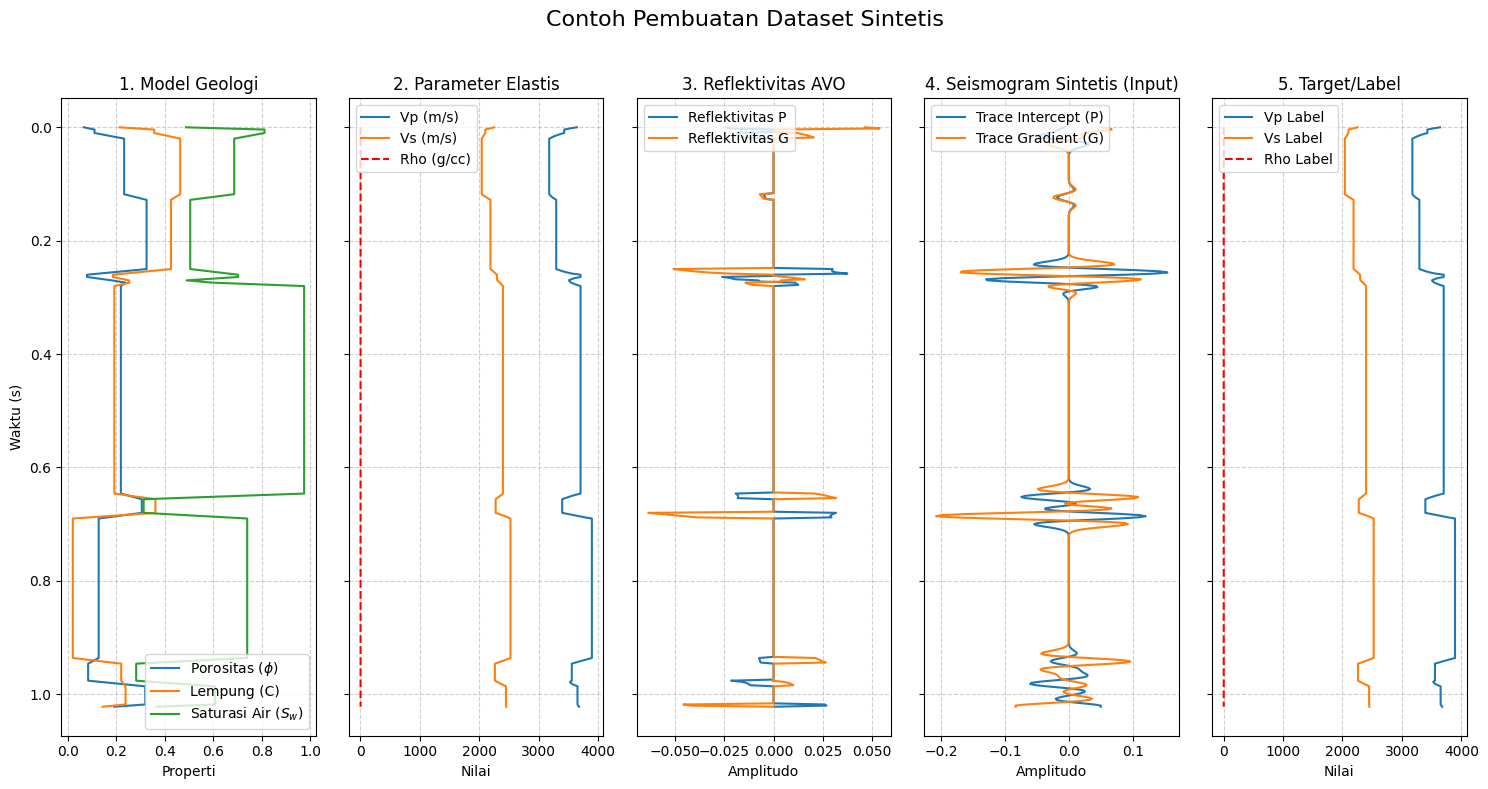

Membuat 1000 model sintetis...
  Model 100/1000 telah dibuat.
  Model 200/1000 telah dibuat.
  Model 300/1000 telah dibuat.
  Model 400/1000 telah dibuat.
  Model 500/1000 telah dibuat.
  Model 600/1000 telah dibuat.
  Model 700/1000 telah dibuat.
  Model 800/1000 telah dibuat.
  Model 900/1000 telah dibuat.
  Model 1000/1000 telah dibuat.

Dimensi data input (X): (1000, 512, 2)
Dimensi data label (Y): (1000, 512, 3)

Dataset telah disimpan sebagai 'synthetic_avo_dataset_X.npy' dan 'synthetic_avo_dataset_Y.npy'


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# LANGKAH 1: DEFINISIKAN KONSTANTA FISIKA BATUAN
# =============================================================================
# Properti mineral (Kuarsa dan Lempung)
K_q, G_q = 36.6, 45.0  # Modulus Bulk & Geser Kuarsa (GPa)
rho_q = 2.65           # Densitas Kuarsa (g/cc)
K_c, G_c = 21.0, 7.0   # Modulus Bulk & Geser Lempung (GPa)
rho_c = 2.58           # Densitas Lempung (g/cc)

# Properti fluida (Air dan Minyak)
K_w, rho_w = 2.25, 1.0  # Modulus Bulk & Densitas Air (GPa, g/cc)
K_o, rho_o = 0.9, 0.7   # Modulus Bulk & Densitas Minyak (GPa, g/cc)

# Parameter lainnya
coord_num = 9      # Coordination number untuk model Hertz-Mindlin
pressure = 20      # Tekanan efektif (MPa)
f_wavelet = 30     # Frekuensi dominan Ricker wavelet (Hz)
dt = 0.002         # Sampling interval waktu (s)

# =============================================================================
# LANGKAH 2: FUNGSI-FUNGSI PEMBANTU
# =============================================================================

def create_geological_model(n_samples=512, n_layers=10, smooth_window=5):
    """Membuat model geologi 1D (log) yang halus untuk porositas, lempung, dan saturasi air."""
    t = np.arange(0, n_samples * dt, dt)
    phi = np.zeros(n_samples)
    clay = np.zeros(n_samples)
    sw = np.zeros(n_samples)
    
    layer_boundaries = np.sort(np.random.randint(0, n_samples, n_layers - 1))
    layer_boundaries = np.concatenate(([0], layer_boundaries, [n_samples]))
    
    for i in range(n_layers):
        start, end = layer_boundaries[i], layer_boundaries[i+1]
        phi[start:end] = np.random.uniform(0.05, 0.35)
        clay[start:end] = np.random.uniform(0.0, 0.5)
        sw[start:end] = np.random.uniform(0.1, 1.0)
        
    # Menghaluskan model 'blocky'
    smoothing_filter = np.ones(smooth_window) / smooth_window
    phi_smooth = np.convolve(phi, smoothing_filter, mode='same')
    clay_smooth = np.convolve(clay, smoothing_filter, mode='same')
    sw_smooth = np.convolve(sw, smoothing_filter, mode='same')
    
    return phi_smooth, clay_smooth, sw_smooth, t

def rock_physics_model(phi, clay, sw):
    """Mengkonversi properti geologi ke parameter elastis menggunakan model fisika batuan."""
    # 1. Modulus Matriks (Batas Hashin-Shtrikman)
    f_c = clay
    f_q = 1 - f_c
    
    k_u_hs = f_q * K_q + f_c * K_c - (f_c * f_q * (K_q - K_c)**2) / (f_c * G_q + f_q * G_c + G_q)
    k_l_hs = f_q * K_q + f_c * K_c - (f_c * f_q * (K_q - K_c)**2) / (f_c * G_q + f_q * G_c + K_q)
    K_m = (k_u_hs + k_l_hs) / 2 # Rata-rata batas atas dan bawah

    g_u_hs = f_q * G_q + f_c * G_c - (f_c * f_q * (G_q - G_c)**2) / (f_c * G_c + f_q * G_q + (K_q + 2*G_q)/3)
    g_l_hs = f_q * G_q + f_c * G_c - (f_c * f_q * (G_q - G_c)**2) / (f_c * G_c + f_q * G_q + (K_c + 2*G_c)/3)
    G_m = (g_u_hs + g_l_hs) / 2
    
    rho_m = f_q * rho_q + f_c * rho_c

    # 2. Modulus Fluida (Rata-rata Reuss)
    K_fl = 1 / (sw / K_w + (1 - sw) / K_o)
    rho_fl = sw * rho_w + (1 - sw) * rho_o

    # 3. Modulus Batuan Kering (Hertz-Mindlin)
    G_crit = G_m / (6 * (1 - phi))
    K_HM = (pressure * (coord_num**2 * (1 - phi)**2 * G_crit**2) / (18 * np.pi**2 * (1 - 2*0.2)**2))**(1/3)
    G_HM = ((5-4*0.2)/(5*(2-0.2)))*((pressure*(3*coord_num**2*(1-phi)**2*G_crit**2))/(2*np.pi**2*(1-2*0.2)**2))**(1/3)

    # 4. Substitusi Fluida (Gassmann)
    K_sat = K_HM + (1 - K_HM / K_m)**2 / ((phi / K_fl) + ((1 - phi) / K_m) - (K_HM / K_m**2))
    G_sat = G_HM # Modulus geser tidak berubah
    
    # 5. Hitung Vp, Vs, dan Densitas
    rho_sat = rho_m * (1 - phi) + rho_fl * phi
    
    vp = np.sqrt((K_sat + 4/3 * G_sat) / rho_sat) * 1000 # konversi ke m/s
    vs = np.sqrt(G_sat / rho_sat) * 1000 # konversi ke m/s
    
    # Menghindari pembagian dengan nol atau nilai tak valid
    vp = np.nan_to_num(vp, nan=np.mean(vp[~np.isnan(vp)]))
    vs = np.nan_to_num(vs, nan=np.mean(vs[~np.isnan(vs)]))
    
    return vp, vs, rho_sat

def calculate_avo_reflectivity(vp, vs, rho):
    """Menghitung reflektivitas Intercept (P) dan Gradient (G) dari log elastis."""
    n_samples = len(vp)
    rc_p = np.zeros(n_samples)
    rc_g = np.zeros(n_samples)
    
    for i in range(n_samples - 1):
        vp_avg = (vp[i+1] + vp[i]) / 2
        vs_avg = (vs[i+1] + vs[i]) / 2
        rho_avg = (rho[i+1] + rho[i]) / 2
        
        delta_vp = vp[i+1] - vp[i]
        delta_vs = vs[i+1] - vs[i]
        delta_rho = rho[i+1] - rho[i]
        
        # Aproksimasi Aki-Richards 2-term
        rc_p[i] = 0.5 * (delta_vp / vp_avg + delta_rho / rho_avg)
        rc_g[i] = 0.5 * (delta_vp / vp_avg) - 2 * (vs_avg**2 / vp_avg**2) * (2 * delta_vs / vs_avg + delta_rho / rho_avg)
        
    return rc_p, rc_g

def create_ricker_wavelet(f, dt, length=0.128):
    """Membuat Ricker wavelet."""
    t = np.arange(-length/2, (length/2), dt)
    t2 = t**2
    f2 = f**2
    y = (1 - 2 * np.pi**2 * f2 * t2) * np.exp(-np.pi**2 * f2 * t2)
    return y

def generate_synthetic_seismic(rc_p, rc_g, wavelet):
    """Melakukan konvolusi untuk menghasilkan seismogram sintetis."""
    seis_p = np.convolve(rc_p, wavelet, mode='same')
    seis_g = np.convolve(rc_g, wavelet, mode='same')
    return seis_p, seis_g

# =============================================================================
# LANGKAH 3: GABUNGKAN SEMUA UNTUK MEMBUAT SATU CONTOH DATASET
# =============================================================================

def generate_one_sample(plot=False):
    """Fungsi utama untuk menghasilkan satu pasang data (input, label)."""
    # 1. Buat model geologi
    phi, clay, sw, t = create_geological_model()
    
    # 2. Hitung parameter elastis
    vp, vs, rho = rock_physics_model(phi, clay, sw)
    
    # 3. Hitung reflektivitas AVO
    rc_p, rc_g = calculate_avo_reflectivity(vp, vs, rho)
    
    # 4. Buat wavelet dan seismogram
    wavelet = create_ricker_wavelet(f_wavelet, dt)
    seis_p, seis_g = generate_synthetic_seismic(rc_p, rc_g, wavelet)
    
    # Gabungkan input dan label
    input_seismic = np.stack([seis_p, seis_g], axis=-1)  # Shape: (n_samples, 2)
    label_logs = np.stack([vp, vs, rho], axis=-1)       # Shape: (n_samples, 3)
    
    if plot:
        # Visualisasi hasil
        fig, axs = plt.subplots(1, 5, figsize=(15, 8), sharey=True)
        fig.suptitle('Contoh Pembuatan Dataset Sintetis', fontsize=16)

        axs[0].plot(phi, t, label='Porositas ($\phi$)')
        axs[0].plot(clay, t, label='Lempung (C)')
        axs[0].plot(sw, t, label='Saturasi Air ($S_w$)')
        axs[0].set_title('1. Model Geologi')
        axs[0].set_xlabel('Properti')
        axs[0].set_ylabel('Waktu (s)')
        axs[0].legend()
        axs[0].invert_yaxis()

        axs[1].plot(vp, t, label='Vp (m/s)')
        axs[1].plot(vs, t, label='Vs (m/s)')
        axs[1].plot(rho, t, label='Rho (g/cc)', color='red', linestyle='--')
        axs[1].set_title('2. Parameter Elastis')
        axs[1].set_xlabel('Nilai')
        axs[1].legend()

        axs[2].plot(rc_p, t, label='Reflektivitas P')
        axs[2].plot(rc_g, t, label='Reflektivitas G')
        axs[2].set_title('3. Reflektivitas AVO')
        axs[2].set_xlabel('Amplitudo')
        axs[2].legend()

        axs[3].plot(seis_p, t, label='Trace Intercept (P)')
        axs[3].plot(seis_g, t, label='Trace Gradient (G)')
        axs[3].set_title('4. Seismogram Sintetis (Input)')
        axs[3].set_xlabel('Amplitudo')
        axs[3].legend()

        axs[4].plot(label_logs[:,0], t, label='Vp Label')
        axs[4].plot(label_logs[:,1], t, label='Vs Label')
        axs[4].plot(label_logs[:,2], t, label='Rho Label', color='red', linestyle='--')
        axs[4].set_title('5. Target/Label')
        axs[4].set_xlabel('Nilai')
        axs[4].legend()

        for ax in axs:
            ax.grid(True, linestyle='--', alpha=0.6)
            
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    return input_seismic, label_logs

# =============================================================================
# LANGKAH 4: BUAT DATASET LENGKAP DAN SIMPAN
# =============================================================================

def create_and_save_dataset(num_of_models=1000, filename_prefix='synthetic_avo_dataset'):
    """Membuat dataset dengan banyak model dan menyimpannya ke file."""
    
    all_inputs = []
    all_labels = []
    
    print(f"Membuat {num_of_models} model sintetis...")
    
    for i in range(num_of_models):
        input_data, label_data = generate_one_sample(plot=False)
        all_inputs.append(input_data)
        all_labels.append(label_data)
        if (i+1) % 100 == 0:
            print(f"  Model {i+1}/{num_of_models} telah dibuat.")
            
    # Konversi list ke numpy array
    X_data = np.array(all_inputs)
    Y_data = np.array(all_labels)
    
    # Cek dimensi: (jumlah_model, jumlah_sampel_waktu, jumlah_channel)
    print(f"\nDimensi data input (X): {X_data.shape}")
    print(f"Dimensi data label (Y): {Y_data.shape}")
    
    # Simpan ke file .npy
    np.save(f'{filename_prefix}_X.npy', X_data)
    np.save(f'{filename_prefix}_Y.npy', Y_data)
    
    print(f"\nDataset telah disimpan sebagai '{filename_prefix}_X.npy' dan '{filename_prefix}_Y.npy'")

# =============================================================================
# EKSEKUSI PROGRAM
# =============================================================================

if __name__ == '__main__':
    # 1. Jalankan untuk membuat dan memvisualisasikan satu contoh
    print("Membuat satu contoh data dan memvisualisasikannya...")
    generate_one_sample(plot=True)
    
    # 2. Jalankan untuk membuat dataset lengkap (misal 1000 model)
    #    (Hapus tanda # di bawah ini untuk menjalankan)
    create_and_save_dataset(num_of_models=1000)

Membuat satu contoh data dan memvisualisasikannya...
Membuat perpustakaan parameter elastis lengkap...
Menghasilkan 45085 set parameter elastis yang valid secara fisik.


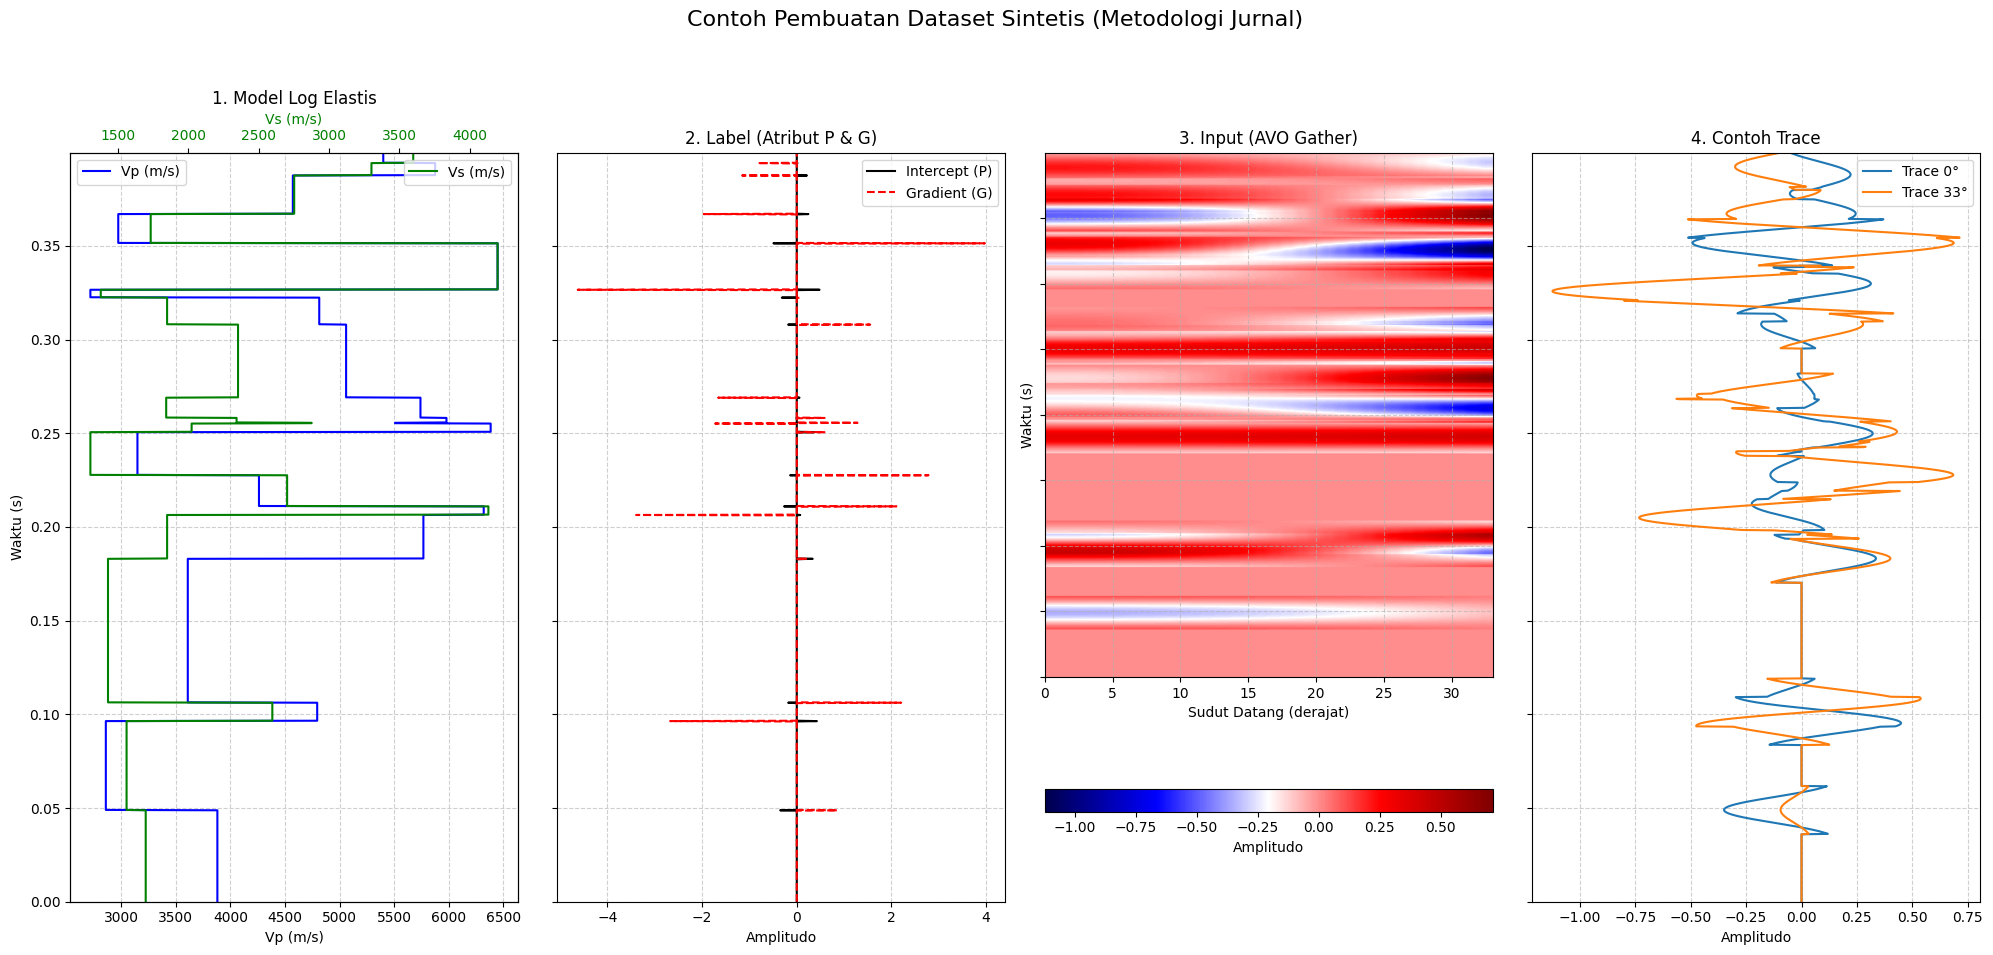

Membuat perpustakaan parameter elastis lengkap...
Menghasilkan 45063 set parameter elastis yang valid secara fisik.

Membuat 38898 model sintetis...


100%|███████████████████████████████████████████████████████████████████████████| 38898/38898 [01:09<00:00, 558.64it/s]



Dimensi data input (X): (38898, 256, 34)
Dimensi data label (Y): (38898, 256, 2)

Dataset telah disimpan sebagai 'csdd_avo_dataset_X.npy' dan 'csdd_avo_dataset_Y.npy'


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Berguna untuk melihat progress bar saat membuat dataset besar

# =============================================================================
# LANGKAH 1: DEFINISIKAN PARAMETER SESUAI JURNAL
# =============================================================================
# Parameter ini diambil langsung dari metodologi penelitian Sun et al. (2023)

# Rentang parameter elastis untuk dijelajahi [1]
VP_RANGE = (2000, 6500)  # m/s
VS_RANGE = (1000, 4500)  # m/s

# Batasan fisik berdasarkan Rasio Poisson [1]
POISSON_RATIO_RANGE = (0.05, 0.45)

# Parameter untuk pembuatan densitas (Gardner + Gaussian Noise) [1]
GARDNER_A = 310  # Koefisien Gardner (SI, untuk Vp dalam m/s)
GARDNER_B = 0.25
DENSITY_VARIANCE = 0.115  # Varians untuk noise Gaussian pada densitas [1]

# Parameter Wavelet dan Seismik [1]
F_WAVELET = 24  # Frekuensi dominan Ricker wavelet (Hz), sesuai jurnal
DT = 0.0002      # Sampling interval waktu (s)
WAVELET_LENGTH = 0.0256  # Panjang wavelet dalam detik

# Parameter untuk AVO Gathers
ANGLES = np.arange(0, 34, 1)  # Contoh sudut datang dari 0 hingga 32 derajat

# Jumlah total sampel yang akan dibuat, sesuai jurnal [1]
TOTAL_SAMPLES = 38898

# =============================================================================
# LANGKAH 2: FUNGSI-FUNGSI PEMBANTU SESUAI METODOLOGI JURNAL
# =============================================================================


def create_ricker_wavelet(f, dt, length):
    """Membuat Ricker wavelet."""
    t = np.arange(-length/2, length/2, dt)
    t2 = t**2
    f2 = f**2
    y = (1 - 2 * np.pi**2 * f2 * t2) * np.exp(-np.pi**2 * f2 * t2)
    return y


def calculate_poisson_ratio(vp, vs):
    """Menghitung rasio Poisson dari Vp dan Vs."""
    return ((vp**2) - 2*(vs**2)) / (2 * ((vp**2) - (vs**2)))


def gardner_density(vp):
    """Menghitung densitas dari Vp menggunakan rumus Gardner (SI)."""
    # Rumus asli: rho = a * Vp^b, dengan rho dalam g/cc dan Vp dalam ft/s
    # Konversi ke SI: rho (kg/m^3) = 310 * Vp(m/s)^0.25
    # Kita akan bekerja dalam g/cc dan m/s, jadi rho = 0.31 * Vp^0.25
    return 0.31 * (vp**0.25)


def create_complete_elastic_dataset(num_points=100000):
    """
    Membuat 'perpustakaan' parameter elastis yang lengkap dengan batasan fisik.
    Ini adalah inti dari pendekatan CSDD. [1]
    """
    print("Membuat perpustakaan parameter elastis lengkap...")

    # 1. Hasilkan Vp dan Vs secara acak dalam rentang yang ditentukan
    vps = np.random.uniform(VP_RANGE[0], VP_RANGE[1], num_points)
    vss = np.random.uniform(VS_RANGE[0], VS_RANGE[1], num_points)

    # 2. Terapkan batasan fisik menggunakan Rasio Poisson
    poisson_ratios = calculate_poisson_ratio(vps, vss)
    valid_indices = np.where(
        (poisson_ratios >= POISSON_RATIO_RANGE[0]) &
        (poisson_ratios <= POISSON_RATIO_RANGE[1]) &
        (vps > vss * np.sqrt(2))  # Memastikan penyebut di rasio poisson tidak negatif
    )[0]

    valid_vps = vps[valid_indices]
    valid_vss = vss[valid_indices]

    # 3. Hasilkan densitas menggunakan Gardner + Gaussian Noise
    baseline_rhos = gardner_density(valid_vps)
    noise = np.random.normal(0, np.sqrt(DENSITY_VARIANCE), len(valid_vps))
    final_rhos = baseline_rhos + noise

    # Pastikan densitas tetap dalam rentang yang wajar (misal > 1.5 g/cc)
    final_indices = np.where(final_rhos > 1.5)[0]

    print(
        f"Menghasilkan {len(final_indices)} set parameter elastis yang valid secara fisik.")

    return np.stack([
        valid_vps[final_indices],
        valid_vss[final_indices],
        final_rhos[final_indices]
    ], axis=1)


def shuey_approximation(vp1, vs1, rho1, vp2, vs2, rho2):
    """
    Menghitung reflektivitas Intercept (P) dan Gradient (G) menggunakan
    aproksimasi Shuey, seperti yang digunakan dalam jurnal. [1]
    """
    # Hitung properti rata-rata di antarmuka
    vp_avg = (vp1 + vp2) / 2
    vs_avg = (vs1 + vs2) / 2
    rho_avg = (rho1 + rho2) / 2

    # Hitung kontras
    delta_vp = vp2 - vp1
    delta_vs = vs2 - vs1
    delta_rho = rho2 - rho1

    # Hitung rasio poisson rata-rata
    pr_avg = calculate_poisson_ratio(vp_avg, vs_avg)

    # Hitung Intercept (P) atau R0
    P = 0.5 * (delta_vp / vp_avg + delta_rho / rho_avg)

    # Hitung Gradient (G)
    A0 = P - 2 * (1 + P) * (1 - 2*pr_avg) / (1 - pr_avg)  # Term A0 dari Shuey
    delta_pr_term = (delta_vp/vp_avg - (2*vs_avg/vp_avg)**2 *
                    (delta_rho/rho_avg + 2*delta_vs/vs_avg)) / (1-pr_avg)**2
    G = A0 * P + delta_pr_term

    return P, G


def generate_one_sample(elastic_library, n_layers=20, n_samples_time=256):
    """
    Fungsi utama untuk menghasilkan satu pasang data (input AVO gather, label P & G).
    """
    # 1. Buat model log 1D 'blocky' dengan memilih secara acak dari perpustakaan elastis [1]
    layer_indices = np.random.randint(0, len(elastic_library), n_layers)
    log_vp = np.zeros(n_samples_time)
    log_vs = np.zeros(n_samples_time)
    log_rho = np.zeros(n_samples_time)

    layer_boundaries = np.sort(np.random.randint(
        1, n_samples_time-1, n_layers - 1))
    layer_boundaries = np.concatenate(([0], layer_boundaries, [n_samples_time]))

    for i in range(n_layers):
        start, end = layer_boundaries[i], layer_boundaries[i+1]
        vp, vs, rho = elastic_library[layer_indices[i]]
        log_vp[start:end] = vp
        log_vs[start:end] = vs
        log_rho[start:end] = rho

    # 2. Hitung reflektivitas P dan G (LABEL) di setiap antarmuka
    rc_p = np.zeros(n_samples_time)
    rc_g = np.zeros(n_samples_time)
    for i in range(n_samples_time - 1):
        P, G = shuey_approximation(log_vp[i], log_vs[i], log_rho[i],
                                   log_vp[i+1], log_vs[i+1], log_rho[i+1])
        rc_p[i] = P
        rc_g[i] = G

    # 3. Buat AVO Gather (INPUT)
    avo_gather = np.zeros((n_samples_time, len(ANGLES)))
    angles_rad = np.deg2rad(ANGLES)

    # Hitung reflektivitas untuk setiap sudut
    reflectivity_angle = rc_p[:, np.newaxis] + rc_g[:, np.newaxis] * np.sin(angles_rad)**2

    # Lakukan konvolusi dengan wavelet untuk setiap trace sudut
    wavelet = create_ricker_wavelet(F_WAVELET, DT, WAVELET_LENGTH)
    for i in range(len(ANGLES)):
        avo_gather[:, i] = np.convolve(
            reflectivity_angle[:, i], wavelet, mode='same')

    # Gabungkan label P dan G
    labels_pg = np.stack([rc_p, rc_g], axis=-1)

    return avo_gather, labels_pg, (log_vp, log_vs, log_rho)


def visualize_sample(avo_gather, labels_pg, logs, t):
    """Fungsi untuk memvisualisasikan satu sampel yang dihasilkan."""
    log_vp, log_vs, log_rho = logs
    fig, axs = plt.subplots(1, 4, figsize=(20, 10), sharey=True)
    fig.suptitle('Contoh Pembuatan Dataset Sintetis (Metodologi Jurnal)', fontsize=16)

    # Plot 1: Model Log Elastis
    axs[0].plot(log_vp, t, label='Vp (m/s)', color='blue')
    axs[0].set_xlabel('Vp (m/s)')
    axs[0].set_title('1. Model Log Elastis')
    ax0_twin = axs[0].twiny()
    ax0_twin.plot(log_vs, t, label='Vs (m/s)', color='green')
    ax0_twin.set_xlabel('Vs (m/s)', color='green')
    ax0_twin.tick_params(axis='x', labelcolor='green')
    axs[0].legend(loc='upper left')
    ax0_twin.legend(loc='upper right')
    axs[0].invert_yaxis()
    axs[0].set_ylabel('Waktu (s)')

    # Plot 2: Label (Atribut P dan G)
    axs[1].plot(labels_pg[:, 0], t, label='Intercept (P)', color='black')
    axs[1].plot(labels_pg[:, 1], t, label='Gradient (G)', color='red', linestyle='--')
    axs[1].set_title('2. Label (Atribut P & G)')
    axs[1].set_xlabel('Amplitudo')
    axs[1].legend()

    # Plot 3: Input (AVO Gather)
    extent = [ANGLES[0], ANGLES[-1], t[-1], t[0]]
    im = axs[2].imshow(avo_gather, aspect='auto', cmap='seismic', 
                      extent=extent)
    axs[2].set_title('3. Input (AVO Gather)')
    axs[2].set_xlabel('Sudut Datang (derajat)')
    axs[2].set_ylabel('Waktu (s)')
    fig.colorbar(im, ax=axs[2], orientation='horizontal', label='Amplitudo')

    # Plot 4: Contoh Trace dari AVO Gather
    axs[3].plot(avo_gather[:, 0], t, label=f'Trace {ANGLES[0]}°')
    axs[3].plot(avo_gather[:, -1], t, label=f'Trace {ANGLES[-1]}°')
    axs[3].set_title('4. Contoh Trace')
    axs[3].set_xlabel('Amplitudo')
    axs[3].legend()
    axs[3].invert_yaxis()

    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# =============================================================================
# LANGKAH 3: BUAT DATASET LENGKAP DAN SIMPAN
# =============================================================================


def create_and_save_dataset(num_of_models=TOTAL_SAMPLES, filename_prefix='csdd_avo_dataset'):
    """Membuat dataset dengan banyak model dan menyimpannya ke file."""

    # Buat perpustakaan parameter elastis sekali saja
    elastic_library = create_complete_elastic_dataset()

    all_inputs = []
    all_labels = []

    print(f"\nMembuat {num_of_models} model sintetis...")

    for _ in tqdm(range(num_of_models)):
        input_data, label_data, _ = generate_one_sample(elastic_library)
        all_inputs.append(input_data)
        all_labels.append(label_data)

    # Konversi list ke numpy array
    X_data = np.array(all_inputs)
    Y_data = np.array(all_labels)

    # Cek dimensi: (jumlah_model, jumlah_sampel_waktu, jumlah_channel)
    print(f"\nDimensi data input (X): {X_data.shape}")  # (num_models, n_samples_time, n_angles)
    print(f"Dimensi data label (Y): {Y_data.shape}")  # (num_models, n_samples_time, 2)

    # Simpan ke file.npy
    np.save(f'{filename_prefix}_X.npy', X_data)
    np.save(f'{filename_prefix}_Y.npy', Y_data)

    print(f"\nDataset telah disimpan sebagai '{filename_prefix}_X.npy' dan '{filename_prefix}_Y.npy'")


# =============================================================================
# EKSEKUSI PROGRAM
# =============================================================================

if __name__ == '__main__':
    # 1. Buat dan visualisasikan satu contoh untuk verifikasi
    print("Membuat satu contoh data dan memvisualisasikannya...")
    temp_library = create_complete_elastic_dataset(100000)
    n_samples_time = 2000
    t_axis = np.arange(0, n_samples_time * DT, DT)
    input_s, label_s, logs_s = generate_one_sample(
        temp_library, n_samples_time=n_samples_time)
    visualize_sample(input_s, label_s, logs_s, t_axis)

    # 2. Jalankan untuk membuat dataset lengkap sesuai jumlah di jurnal
    #    (Hapus tanda # di bawah ini untuk menjalankan pembuatan dataset penuh)
    create_and_save_dataset(num_of_models=TOTAL_SAMPLES)

Membuat satu contoh data dan memvisualisasikannya untuk verifikasi...
Membuat perpustakaan parameter elastis lengkap...
Menghasilkan 45038 set parameter elastis yang valid secara fisik.


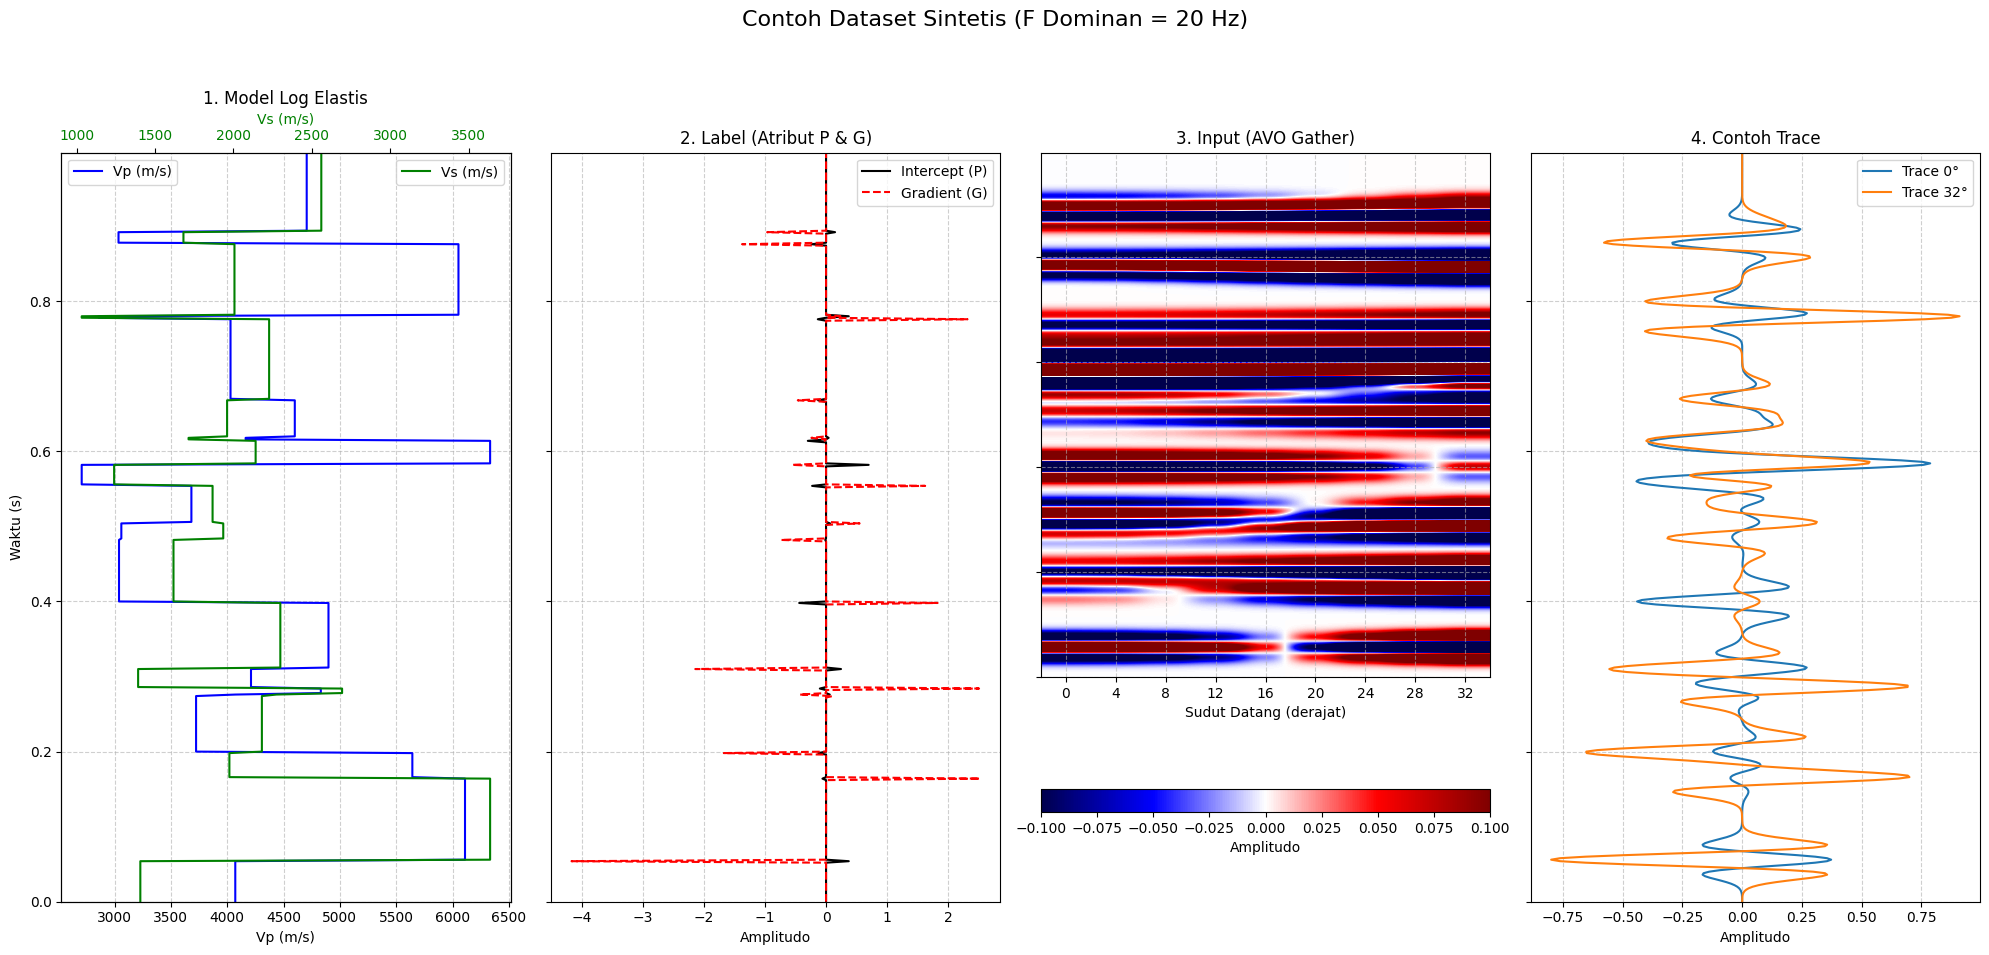

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# =============================================================================
# LANGKAH 1: DEFINISIKAN PARAMETER SESUAI JURNAL (Sun et al., 2023)
# =============================================================================

VP_RANGE = (2000, 6500)
VS_RANGE = (1000, 4500)
POISSON_RATIO_RANGE = (0.05, 0.45)
GARDNER_A = 310
GARDNER_B = 0.25
DENSITY_VARIANCE = 0.115
F_WAVELET = 20
DT = 0.002
WAVELET_LENGTH = 0.256
ANGLES = np.arange(0, 33, 4)
TOTAL_SAMPLES = 38898
N_SAMPLES_TIME = 500

# =============================================================================
# LANGKAH 2: FUNGSI-FUNGSI PEMBANTU SESUAI METODOLOGI JURNAL
# =============================================================================

def create_ricker_wavelet(f, dt, length):
    t = np.arange(-length/2, length/2, dt)
    t2 = t**2
    f2 = f**2
    y = (1 - 2 * np.pi**2 * f2 * t2) * np.exp(-np.pi**2 * f2 * t2)
    return y

# --- PERBAIKAN ERROR DI SINI ---
def calculate_poisson_ratio(vp, vs):
    """
    Menghitung rasio Poisson dari Vp dan Vs.
    Fungsi ini sekarang dapat menangani input berupa array numpy atau angka tunggal (float).
    """
    vp2 = vp**2
    vs2 = vs**2
    denominator = 2 * (vp2 - vs2)

    # Cek apakah 'denominator' adalah sebuah array atau angka tunggal
    if isinstance(denominator, np.ndarray):
        # Jika array, gunakan masking untuk mengganti semua nilai 0
        denominator[denominator == 0] = 1e-9
    else:
        # Jika angka tunggal, gunakan pengecekan if biasa
        if denominator == 0:
            denominator = 1e-9

    return (vp2 - 2*vs2) / denominator

def gardner_density(vp):
    return 0.31 * (vp**0.25)

def create_complete_elastic_dataset(num_points=100000):
    print("Membuat perpustakaan parameter elastis lengkap...")
    vps = np.random.uniform(VP_RANGE[0], VP_RANGE[1], num_points)
    vss = np.random.uniform(VS_RANGE[0], VS_RANGE[1], num_points)
    poisson_ratios = calculate_poisson_ratio(vps, vss)
    valid_indices = np.where(
        (poisson_ratios >= POISSON_RATIO_RANGE[0]) &
        (poisson_ratios <= POISSON_RATIO_RANGE[1]) &
        (vps > vss * np.sqrt(2))
    )[0]
    valid_vps = vps[valid_indices]
    valid_vss = vss[valid_indices]
    baseline_rhos = gardner_density(valid_vps)
    noise = np.random.normal(0, np.sqrt(DENSITY_VARIANCE), len(valid_vps))
    final_rhos = baseline_rhos + noise
    final_indices = np.where(final_rhos > 1.5)[0]
    print(f"Menghasilkan {len(final_indices)} set parameter elastis yang valid secara fisik.")
    return np.stack([
        valid_vps[final_indices],
        valid_vss[final_indices],
        final_rhos[final_indices]
    ], axis=1)

def shuey_approximation(vp1, vs1, rho1, vp2, vs2, rho2):
    vp_avg = (vp1 + vp2) / 2
    vs_avg = (vs1 + vs2) / 2
    rho_avg = (rho1 + rho2) / 2
    delta_vp = vp2 - vp1
    delta_vs = vs2 - vs1
    delta_rho = rho2 - rho1
    pr_avg = calculate_poisson_ratio(vp_avg, vs_avg)
    
    # Menghindari pembagian dengan nol jika pr_avg == 1
    if (1 - pr_avg) == 0 or (1-pr_avg)**2 == 0:
        return 0.0, 0.0 # Return nilai netral jika terjadi kondisi singularitas
        
    P = 0.5 * (delta_vp / vp_avg + delta_rho / rho_avg)
    A0 = P - 2 * (1 + P) * (1 - 2*pr_avg) / (1 - pr_avg)
    delta_pr_term = (delta_vp/vp_avg - (2*vs_avg/vp_avg)**2 *
                     (delta_rho/rho_avg + 2*delta_vs/vs_avg)) / (1-pr_avg)**2
    G = A0 * P + delta_pr_term
    return P, G

def generate_one_sample(elastic_library, n_layers=20, n_samples_time=N_SAMPLES_TIME):
    layer_indices = np.random.randint(0, len(elastic_library), n_layers)
    log_vp, log_vs, log_rho = (np.zeros(n_samples_time) for _ in range(3))
    layer_boundaries = np.sort(np.random.randint(1, n_samples_time-1, n_layers - 1))
    layer_boundaries = np.concatenate(([0], layer_boundaries, [n_samples_time]))
    for i in range(n_layers):
        start, end = layer_boundaries[i], layer_boundaries[i+1]
        vp, vs, rho = elastic_library[layer_indices[i]]
        log_vp[start:end] = vp
        log_vs[start:end] = vs
        log_rho[start:end] = rho
    rc_p, rc_g = (np.zeros(n_samples_time) for _ in range(2))
    for i in range(n_samples_time - 1):
        P, G = shuey_approximation(log_vp[i], log_vs[i], log_rho[i],
                                     log_vp[i+1], log_vs[i+1], log_rho[i+1])
        rc_p[i], rc_g[i] = P, G
    avo_gather = np.zeros((n_samples_time, len(ANGLES)))
    angles_rad = np.deg2rad(ANGLES)
    reflectivity_angle = rc_p[:, np.newaxis] + rc_g[:, np.newaxis] * np.sin(angles_rad)**2
    wavelet = create_ricker_wavelet(F_WAVELET, DT, WAVELET_LENGTH)
    for i in range(len(ANGLES)):
        avo_gather[:, i] = np.convolve(reflectivity_angle[:, i], wavelet, mode='same')
    labels_pg = np.stack([rc_p, rc_g], axis=-1)
    return avo_gather, labels_pg, (log_vp, log_vs, log_rho)

def visualize_sample(avo_gather, labels_pg, logs, t):
    log_vp, log_vs, log_rho = logs
    fig, axs = plt.subplots(1, 4, figsize=(20, 10), sharey=True)
    fig.suptitle(f'Contoh Dataset Sintetis (F Dominan = {F_WAVELET} Hz)', fontsize=16)
    axs[0].plot(log_vp, t, label='Vp (m/s)', color='blue')
    axs[0].set_xlabel('Vp (m/s)'); axs[0].set_title('1. Model Log Elastis')
    ax0_twin = axs[0].twiny()
    ax0_twin.plot(log_vs, t, label='Vs (m/s)', color='green')
    ax0_twin.set_xlabel('Vs (m/s)', color='green'); ax0_twin.tick_params(axis='x', labelcolor='green')
    axs[0].legend(loc='upper left'); ax0_twin.legend(loc='upper right')
    axs[0].invert_yaxis(); axs[0].set_ylabel('Waktu (s)')
    axs[1].plot(labels_pg[:, 0], t, label='Intercept (P)', color='black')
    axs[1].plot(labels_pg[:, 1], t, label='Gradient (G)', color='red', linestyle='--')
    axs[1].set_title('2. Label (Atribut P & G)'); axs[1].set_xlabel('Amplitudo'); axs[1].legend()
    extent = [ANGLES[0]-2, ANGLES[-1]+2, t[-1], t[0]]
    im = axs[2].imshow(avo_gather, aspect='auto', cmap='seismic', extent=extent, vmin=-0.1, vmax=0.1) # Menambahkan vmin/vmax untuk skala warna konsisten
    axs[2].set_title('3. Input (AVO Gather)'); axs[2].set_xlabel('Sudut Datang (derajat)');
    axs[2].set_xticks(ANGLES)
    fig.colorbar(im, ax=axs[2], orientation='horizontal', label='Amplitudo')
    axs[3].plot(avo_gather[:, 0], t, label=f'Trace {ANGLES[0]}°')
    axs[3].plot(avo_gather[:, -1], t, label=f'Trace {ANGLES[-1]}°')
    axs[3].set_title('4. Contoh Trace'); axs[3].set_xlabel('Amplitudo'); axs[3].legend(); axs[3].invert_yaxis()
    for ax in axs: ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()


# =============================================================================
# EKSEKUSI PROGRAM
# =============================================================================

if __name__ == '__main__':
    print("Membuat satu contoh data dan memvisualisasikannya untuk verifikasi...")
    temp_library = create_complete_elastic_dataset(100000)
    t_axis = np.arange(0, N_SAMPLES_TIME * DT, DT)
    input_s, label_s, logs_s = generate_one_sample(temp_library, n_samples_time=N_SAMPLES_TIME)
    visualize_sample(input_s, label_s, logs_s, t_axis)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, Input

def build_csdd_cnn(input_shape):
    """
    Membangun arsitektur Convolutional Neural Network (CNN) sesuai dengan
    Gambar 5 dari jurnal Sun et al. (2023) untuk inversi atribut AVO.

    Args:
        input_shape (tuple): Dimensi dari data input (misal: (window_size, num_angles, 1)).

    Returns:
        tf.keras.Model: Model CNN yang telah dikompilasi dan siap untuk dilatih.
    """
    
    model = Sequential([
        # Input layer, menentukan bentuk data masukan.
        # Inputnya adalah potongan waveform dari AVO gather. [1]
        Input(shape=input_shape),

        # === BLOK KONVOLUSIONAL 1 ===
        # Lapisan konvolusional pertama dengan 128 filter, kernel 3x3, dan aktivasi ReLU. [1]
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='conv1'),
        # Lapisan Average Pooling 2x2. [1]
        AveragePooling2D(pool_size=(2, 2), name='pool1'),

        # === BLOK KONVOLUSIONAL 2 ===
        # Lapisan konvolusional kedua dengan 64 filter dan kernel 3x3. [1]
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name='conv2'),
        # Lapisan Average Pooling 2x2. [1]
        AveragePooling2D(pool_size=(2, 2), name='pool2'),

        # === BLOK KONVOLUSIONAL 3 ===
        # Lapisan konvolusional ketiga dengan 32 filter dan kernel 3x3. [1]
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv3'),
        # Lapisan Average Pooling 2x2. [1]
        AveragePooling2D(pool_size=(2, 2), name='pool3'),

        # Meratakan (flatten) output dari blok konvolusional menjadi vektor 1D
        # untuk dimasukkan ke lapisan Fully Connected.
        Flatten(name='flatten'),

        # === BLOK FULLY CONNECTED (TERHUBUNG PENUH) ===
        # Lapisan terhubung penuh pertama dengan 200 neuron. [1]
        Dense(200, activation='relu', name='fc1'),
        # Teknik regularisasi Dropout untuk mencegah overfitting. [1]
        # Jurnal tidak menyebutkan rate, 0.3 adalah nilai awal yang umum.
        Dropout(0.3, name='dropout1'),

        # Lapisan terhubung penuh kedua dengan 100 neuron. [1]
        Dense(100, activation='relu', name='fc2'),
        Dropout(0.3, name='dropout2'),

        # Lapisan terhubung penuh ketiga dengan 50 neuron. [1]
        Dense(50, activation='relu', name='fc3'),
        Dropout(0.3, name='dropout3'),

        # === LAPISAN OUTPUT ===
        # Lapisan output dengan 2 neuron untuk memprediksi atribut P dan G. [1]
        # Aktivasi 'linear' (default) digunakan untuk tugas regresi.
        Dense(2, name='output')
    ])

    # Mengompilasi model dengan optimizer dan loss function yang disebutkan di jurnal.
    # Optimizer: Adam dengan initial learning rate 0.002. [1]
    # Loss Function: L2-norm, yang setara dengan Mean Squared Error (MSE). [1]
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# =============================================================================
# CONTOH PENGGUNAAN
# =============================================================================
if __name__ == '__main__':
    # Definisikan bentuk input. Berdasarkan kode sebelumnya, kita punya AVO gather
    # dengan beberapa sudut. Misal, window time 64 sampel dan 17 sudut.
    # Dimensi ketiga adalah 1 untuk 'channel', standar untuk input CNN.
    WINDOW_SIZE = 64
    NUM_ANGLES = 17
    INPUT_SHAPE = (WINDOW_SIZE, NUM_ANGLES, 1)

    # Bangun model CNN
    csdd_model = build_csdd_cnn(INPUT_SHAPE)

    # Tampilkan ringkasan arsitektur model untuk verifikasi.
    # Ini akan menunjukkan setiap lapisan, bentuk outputnya, dan jumlah parameter.
    print("Ringkasan Arsitektur CSDD-CNN:")
    csdd_model.summary()

Ringkasan Arsitektur CSDD-CNN:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 64, 17, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (AveragePooling2D)             │ (None, 32, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 32, 8, 64)           │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (AveragePooling2D)             │ (None, 16, 4, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 16, 4, 32)           │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (AveragePooling2D)             │ (None, 8, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 200)                 │         102,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout1 (Dropout)                   │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout2 (Dropout)                   │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc3 (Dense)                          │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout3 (Dropout)                   │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 221,388 (864.80 KB)

 Trainable params: 221,388 (864.80 KB)

 Non-trainable params: 0 (0.00 B)

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import os
import gc
import time

# =============================================================================
# KONFIGURASI UNTUK OPTIMASI CPU
# =============================================================================
# Nonaktifkan fitur GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Konfigurasi TensorFlow untuk CPU
tf.config.threading.set_intra_op_parallelism_threads(8)  # Utilitas core CPU
tf.config.threading.set_inter_op_parallelism_threads(4)  # Paralelisasi antar operasi

# =============================================================================
# FUNGSI UNTUK MEMBANGUN MODEL CNN (Optimasi untuk CPU)
# =============================================================================

def build_csdd_cnn(input_shape):
    inputs = Input(shape=input_shape)
    
    # Block 1
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Block 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Classification block
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(2, activation='linear')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Optimizer khusus CPU
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

# =============================================================================
# GENERATOR DATA DENGAN OPTIMASI MEMORI (PERBAIKAN)
# =============================================================================

class CSDDDataGenerator(tf.keras.utils.Sequence):
    """Generator data dengan optimasi memori untuk CPU"""
    def __init__(self, X_file, Y_file, window_size, num_models, time_samples, num_angles, 
                 model_indices, batch_size=128, stride=4, shuffle=True):
        self.X_file = X_file
        self.Y_file = Y_file
        self.window_size = window_size
        self.num_models = num_models
        self.time_samples = time_samples
        self.num_angles = num_angles
        self.model_indices = model_indices
        self.batch_size = batch_size
        self.stride = stride
        self.shuffle = shuffle
        self.half_window = window_size // 2
        
        # Inisialisasi cache sebelum memanggil on_epoch_end
        self.data_cache = {}
        
        # Hitung jumlah window per model
        self.windows_per_model = (time_samples - window_size) // stride + 1
        
        # Hitung total windows
        self.total_windows = len(model_indices) * self.windows_per_model
        
        # Hitung jumlah batch
        self.num_batches = int(np.ceil(self.total_windows / batch_size))
        
        # Preload indeks untuk akses cepat
        self.on_epoch_end()
        
    def __len__(self):
        return self.num_batches
    
    def load_model_data(self, model_idx):
        """Load data untuk satu model dengan caching"""
        if model_idx not in self.data_cache:
            offset = model_idx * self.time_samples * self.num_angles * 4
            shape = (self.time_samples, self.num_angles)
            
            # Baca data dari file
            with open(self.X_file, 'rb') as f:
                f.seek(offset)
                data = np.frombuffer(f.read(self.time_samples * self.num_angles * 4),
                                     dtype=np.float32)
            self.data_cache[model_idx] = data.reshape(shape)
            
            # Hapus cache jika terlalu besar
            if len(self.data_cache) > 10:
                oldest_key = next(iter(self.data_cache))
                del self.data_cache[oldest_key]
                
        return self.data_cache[model_idx]
    
    def load_label_data(self, model_idx):
        """Load label untuk satu model"""
        offset = model_idx * self.time_samples * 2 * 4
        with open(self.Y_file, 'rb') as f:
            f.seek(offset)
            labels = np.frombuffer(f.read(self.time_samples * 2 * 4),
                                  dtype=np.float32)
        return labels.reshape((self.time_samples, 2))
    
    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, self.total_windows)
        
        batch_X = np.zeros((end_idx - start_idx, self.window_size, self.num_angles, 1), dtype=np.float32)
        batch_y = np.zeros((end_idx - start_idx, 2), dtype=np.float32)
        
        for i in range(start_idx, end_idx):
            model_idx = self.model_indices[i // self.windows_per_model]
            window_idx = i % self.windows_per_model
            
            # Hitung posisi waktu
            start_time = window_idx * self.stride
            end_time = start_time + self.window_size
            
            # Load data
            model_data = self.load_model_data(model_idx)
            label_data = self.load_label_data(model_idx)
            
            # Ekstrak window dan label
            window_data = model_data[start_time:end_time]
            label = label_data[start_time + self.half_window]
            
            batch_X[i - start_idx] = np.expand_dims(window_data, axis=-1)
            batch_y[i - start_idx] = label
        
        return batch_X, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.model_indices)
        # Kosongkan cache setiap akhir epoch
        self.data_cache.clear()
        gc.collect()

# =============================================================================
# FUNGSI UTAMA DENGAN OPTIMASI KINERJA CPU
# =============================================================================

if __name__ == '__main__':
    # --- Parameter ---
    FILENAME_X = 'csdd_avo_dataset_X.npy'
    FILENAME_Y = 'csdd_avo_dataset_Y.npy'
    WINDOW_SIZE = 64
    NUM_ANGLES = 17
    BATCH_SIZE = 128  # Lebih kecil untuk memori CPU
    STRIDE = 4        # Lebih besar untuk mengurangi jumlah window
    TEST_SIZE = 0.1
    
    # --- 1. Dapatkan metadata dataset ---
    print("Mendapatkan metadata dataset...")
    try:
        # Hitung jumlah model berdasarkan ukuran file
        file_size_x = os.path.getsize(FILENAME_X)
        file_size_y = os.path.getsize(FILENAME_Y)
        
        # Asumsi: float32 (4 byte per nilai)
        # X: [models, time_samples, angles]
        # Y: [models, time_samples, 2]
        TIME_SAMPLES = 1000  # Default jika tidak bisa dihitung
        
        # Hitung num_models dari file Y karena lebih konsisten (2 nilai per time sample)
        num_models = file_size_y // (TIME_SAMPLES * 2 * 4)
        
        # Verifikasi dengan file X
        expected_size_x = num_models * TIME_SAMPLES * NUM_ANGLES * 4
        if abs(file_size_x - expected_size_x) > 100:  # Allow small difference
            # Hitung ulang TIME_SAMPLES berdasarkan file X
            TIME_SAMPLES = file_size_x // (num_models * NUM_ANGLES * 4)
            print(f"Menyesuaikan TIME_SAMPLES menjadi: {TIME_SAMPLES}")
        
        print(f"Jumlah model: {num_models}, Time samples: {TIME_SAMPLES}, Angles: {NUM_ANGLES}")
    except Exception as e:
        print(f"Error: {e}")
        exit()

    # --- 2. Bagi indeks model untuk train/val ---
    all_indices = np.arange(num_models)
    train_indices, val_indices = train_test_split(
        all_indices, test_size=TEST_SIZE, random_state=42
    )
    print(f"Data training: {len(train_indices)} model, Data validasi: {len(val_indices)} model")

    # --- 3. Buat generator data ---
    print("Membuat generator data...")
    start_time = time.time()
    
    train_generator = CSDDDataGenerator(
        FILENAME_X, FILENAME_Y, 
        window_size=WINDOW_SIZE,
        num_models=num_models,
        time_samples=TIME_SAMPLES,
        num_angles=NUM_ANGLES,
        model_indices=train_indices,
        batch_size=BATCH_SIZE,
        stride=STRIDE,
        shuffle=True
    )
    
    val_generator = CSDDDataGenerator(
        FILENAME_X, FILENAME_Y, 
        window_size=WINDOW_SIZE,
        num_models=num_models,
        time_samples=TIME_SAMPLES,
        num_angles=NUM_ANGLES,
        model_indices=val_indices,
        batch_size=BATCH_SIZE,
        stride=STRIDE,
        shuffle=False
    )
    
    print(f"Generator dibuat dalam {time.time()-start_time:.2f} detik")
    print(f"Total batch training: {len(train_generator)}, Batch validasi: {len(val_generator)}")

    # --- 4. Bangun dan Latih Model ---
    INPUT_SHAPE = (WINDOW_SIZE, NUM_ANGLES, 1)
    model = build_csdd_cnn(INPUT_SHAPE)
    model.summary()

    # Callbacks sederhana untuk CPU
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        "csdd_cnn_best_model.h5", save_best_only=True, monitor='val_loss', verbose=1
    )
    
    # Early stopping dengan toleransi lebih longgar
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        patience=3, restore_best_weights=True, monitor='val_loss', verbose=1
    )

    print("\nMemulai pelatihan dengan generator data...")
    start_train = time.time()
    
    # Konfigurasi training untuk CPU
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator,
        callbacks=[checkpoint_cb, early_stopping_cb],
        verbose=1,
        workers=4,  # Jumlah worker disesuaikan dengan core CPU
        use_multiprocessing=False,  # Nonaktifkan untuk menghindari overhead
        max_queue_size=10
    )

    print(f"Pelatihan selesai dalam {time.time()-start_train:.2f} detik")
    model.save("csdd_cnn_final_model.h5")

    # Visualisasi
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Kurva Loss Pelatihan')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_curve.png')
    plt.show()

Mendapatkan metadata dataset...
Menyesuaikan TIME_SAMPLES menjadi: 1000
Jumlah model: 19915, Time samples: 1000, Angles: 17
Data training: 17923 model, Data validasi: 1992 model
Membuat generator data...
Generator dibuat dalam 0.48 detik
Total batch training: 32906, Batch validasi: 3658
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 17, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 17, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 17, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 8, 32)         0         
 g2D)                                                            
                                   

KeyboardInterrupt: 

Mendapatkan metadata dataset...
Menyesuaikan TIME_SAMPLES menjadi: 1000
Jumlah model: 19915, Time samples: 1000, Angles: 17
Data training: 17923 model, Data validasi: 1992 model
Membuat generator data...
Generator dibuat dalam 0.25 detik
Total batch training: 32906, Batch validasi: 3658
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 17, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 17, 128)       1280      
                                                                 
 average_pooling2d (Average  (None, 32, 9, 128)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 9, 64)         73792     
                                     

C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


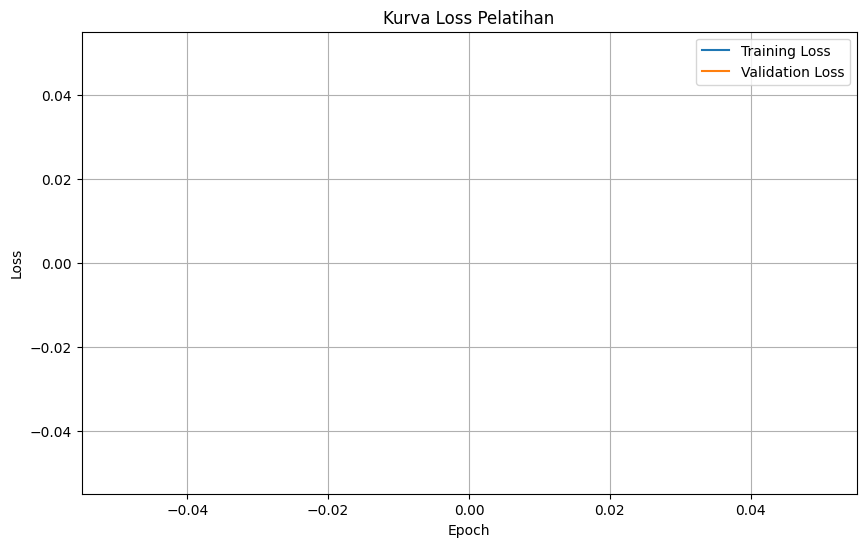

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import os
import gc
import time

# =============================================================================
# KONFIGURASI UNTUK OPTIMASI CPU
# =============================================================================
# Nonaktifkan fitur GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Konfigurasi TensorFlow untuk CPU
tf.config.threading.set_intra_op_parallelism_threads(8)
tf.config.threading.set_inter_op_parallelism_threads(4)

# =============================================================================
# FUNGSI UNTUK MEMBANGUN MODEL CNN SESUAI JURNAL
# =============================================================================

def build_csdd_cnn(input_shape):
    """
    Membangun arsitektur CNN sesuai jurnal Geophysical Prospecting 2023
    Arsitektur: 3 lapisan konvolusi + pooling -> 3 lapisan fully connected
    """
    inputs = Input(shape=input_shape)
    
    # Block 1: Conv -> Pool
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    x = AveragePooling2D((2, 2), padding='same')(x)
    
    # Block 2: Conv -> Pool
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = AveragePooling2D((2, 2), padding='same')(x)
    
    # Block 3: Conv -> Pool
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = AveragePooling2D((2, 2), padding='same')(x)
    
    # Classification block
    x = Flatten()(x)
    x = Dense(200, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout untuk regularisasi
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer untuk atribut P dan G
    outputs = Dense(2, activation='linear')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Optimizer sesuai jurnal
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

# =============================================================================
# GENERATOR DATA DENGAN OPTIMASI MEMORI
# =============================================================================

class CSDDDataGenerator(tf.keras.utils.Sequence):
    """Generator data dengan optimasi memori untuk CPU"""
    def __init__(self, X_file, Y_file, window_size, num_models, time_samples, num_angles, 
                 model_indices, batch_size=128, stride=4, shuffle=True):
        self.X_file = X_file
        self.Y_file = Y_file
        self.window_size = window_size
        self.num_models = num_models
        self.time_samples = time_samples
        self.num_angles = num_angles
        self.model_indices = model_indices
        self.batch_size = batch_size
        self.stride = stride
        self.shuffle = shuffle
        self.half_window = window_size // 2
        
        # Inisialisasi cache
        self.data_cache = {}
        
        # Hitung jumlah window per model
        self.windows_per_model = (time_samples - window_size) // stride + 1
        
        # Hitung total windows
        self.total_windows = len(model_indices) * self.windows_per_model
        
        # Hitung jumlah batch
        self.num_batches = int(np.ceil(self.total_windows / batch_size))
        
        # Preload indeks
        self.on_epoch_end()
        
    def __len__(self):
        return self.num_batches
    
    def load_model_data(self, model_idx):
        """Load data untuk satu model dengan caching"""
        if model_idx not in self.data_cache:
            offset = model_idx * self.time_samples * self.num_angles * 4
            shape = (self.time_samples, self.num_angles)
            
            # Baca data dari file
            with open(self.X_file, 'rb') as f:
                f.seek(offset)
                data = np.frombuffer(f.read(self.time_samples * self.num_angles * 4),
                                     dtype=np.float32)
            self.data_cache[model_idx] = data.reshape(shape)
            
            # Manajemen cache
            if len(self.data_cache) > 10:
                oldest_key = next(iter(self.data_cache))
                del self.data_cache[oldest_key]
                
        return self.data_cache[model_idx]
    
    def load_label_data(self, model_idx):
        """Load label untuk satu model"""
        offset = model_idx * self.time_samples * 2 * 4
        with open(self.Y_file, 'rb') as f:
            f.seek(offset)
            labels = np.frombuffer(f.read(self.time_samples * 2 * 4),
                                  dtype=np.float32)
        return labels.reshape((self.time_samples, 2))
    
    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, self.total_windows)
        
        batch_X = np.zeros((end_idx - start_idx, self.window_size, self.num_angles, 1), dtype=np.float32)
        batch_y = np.zeros((end_idx - start_idx, 2), dtype=np.float32)
        
        for i in range(start_idx, end_idx):
            model_idx = self.model_indices[i // self.windows_per_model]
            window_idx = i % self.windows_per_model
            
            # Hitung posisi waktu
            start_time = window_idx * self.stride
            end_time = start_time + self.window_size
            
            # Load data
            model_data = self.load_model_data(model_idx)
            label_data = self.load_label_data(model_idx)
            
            # Ekstrak window dan label
            window_data = model_data[start_time:end_time]
            label = label_data[start_time + self.half_window]
            
            batch_X[i - start_idx] = np.expand_dims(window_data, axis=-1)
            batch_y[i - start_idx] = label
        
        return batch_X, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.model_indices)
        # Kosongkan cache setiap akhir epoch
        self.data_cache.clear()
        gc.collect()

# =============================================================================
# FUNGSI UTAMA
# =============================================================================

if __name__ == '__main__':
    # --- Parameter sesuai jurnal ---
    FILENAME_X = 'csdd_avo_dataset_X.npy'
    FILENAME_Y = 'csdd_avo_dataset_Y.npy'
    WINDOW_SIZE = 64  # Ukuran window input
    NUM_ANGLES = 17   # Jumlah sudut offset (sesuai jurnal)
    BATCH_SIZE = 128  # Ukuran batch optimal untuk CPU
    STRIDE = 4        # Jarak antar window
    TEST_SIZE = 0.1   # Proporsi data validasi
    
    # --- 1. Dapatkan metadata dataset ---
    print("Mendapatkan metadata dataset...")
    try:
        # Hitung jumlah model berdasarkan ukuran file
        file_size_x = os.path.getsize(FILENAME_X)
        file_size_y = os.path.getsize(FILENAME_Y)
        
        # Asumsi: float32 (4 byte per nilai)
        TIME_SAMPLES = 1000  # Default
        
        # Hitung num_models dari file Y
        num_models = file_size_y // (TIME_SAMPLES * 2 * 4)
        
        # Verifikasi dengan file X
        expected_size_x = num_models * TIME_SAMPLES * NUM_ANGLES * 4
        if abs(file_size_x - expected_size_x) > 100:
            TIME_SAMPLES = file_size_x // (num_models * NUM_ANGLES * 4)
            print(f"Menyesuaikan TIME_SAMPLES menjadi: {TIME_SAMPLES}")
        
        print(f"Jumlah model: {num_models}, Time samples: {TIME_SAMPLES}, Angles: {NUM_ANGLES}")
    except Exception as e:
        print(f"Error: {e}")
        exit()

    # --- 2. Bagi indeks model untuk train/val ---
    all_indices = np.arange(num_models)
    train_indices, val_indices = train_test_split(
        all_indices, test_size=TEST_SIZE, random_state=42
    )
    print(f"Data training: {len(train_indices)} model, Data validasi: {len(val_indices)} model")

    # --- 3. Buat generator data ---
    print("Membuat generator data...")
    start_time = time.time()
    
    train_generator = CSDDDataGenerator(
        FILENAME_X, FILENAME_Y, 
        window_size=WINDOW_SIZE,
        num_models=num_models,
        time_samples=TIME_SAMPLES,
        num_angles=NUM_ANGLES,
        model_indices=train_indices,
        batch_size=BATCH_SIZE,
        stride=STRIDE,
        shuffle=True
    )
    
    val_generator = CSDDDataGenerator(
        FILENAME_X, FILENAME_Y, 
        window_size=WINDOW_SIZE,
        num_models=num_models,
        time_samples=TIME_SAMPLES,
        num_angles=NUM_ANGLES,
        model_indices=val_indices,
        batch_size=BATCH_SIZE,
        stride=STRIDE,
        shuffle=False
    )
    
    print(f"Generator dibuat dalam {time.time()-start_time:.2f} detik")
    print(f"Total batch training: {len(train_generator)}, Batch validasi: {len(val_generator)}")

    # --- 4. Bangun dan Latih Model ---
    INPUT_SHAPE = (WINDOW_SIZE, NUM_ANGLES, 1)
    model = build_csdd_cnn(INPUT_SHAPE)
    model.summary()

    # Callbacks
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        "csdd_cnn_best_model.h5", save_best_only=True, monitor='val_loss', verbose=1
    )
    
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True, monitor='val_loss', verbose=1
    )

    print("\nMemulai pelatihan dengan generator data...")
    start_train = time.time()
    
    # Konfigurasi training
    history = model.fit(
        train_generator,
        epochs=10,  # Sesuai jurnal (biasanya >100 epoch)
        validation_data=val_generator,
        callbacks=[checkpoint_cb, early_stopping_cb],
        verbose=1,
        workers=4,
        use_multiprocessing=False,
        max_queue_size=10
    )

    print(f"Pelatihan selesai dalam {time.time()-start_train:.2f} detik")
    model.save("csdd_cnn_final_model.h5")

    # Visualisasi
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Kurva Loss Pelatihan')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_curve.png')
    plt.show()

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import os
import gc
import time
import threading  # IMPORT BARU UNTUK THREAD SAFETY

# =============================================================================
# KONFIGURASI UNTUK OPTIMASI CPU
# =============================================================================
# Nonaktifkan fitur GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Konfigurasi TensorFlow untuk CPU
tf.config.threading.set_intra_op_parallelism_threads(8)
tf.config.threading.set_inter_op_parallelism_threads(4)

# =============================================================================
# FUNGSI UNTUK MEMBANGUN MODEL CNN SESUAI JURNAL
# =============================================================================

def build_csdd_cnn(input_shape):
    """
    Membangun arsitektur CNN sesuai jurnal Geophysical Prospecting 2023
    Arsitektur: 3 lapisan konvolusi + pooling -> 3 lapisan fully connected
    """
    inputs = Input(shape=input_shape)
    
    # Block 1: Conv -> Pool
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    x = AveragePooling2D((2, 2), padding='same')(x)
    
    # Block 2: Conv -> Pool
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = AveragePooling2D((2, 2), padding='same')(x)
    
    # Block 3: Conv -> Pool
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = AveragePooling2D((2, 2), padding='same')(x)
    
    # Classification block
    x = Flatten()(x)
    x = Dense(200, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout untuk regularisasi
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer untuk atribut P dan G
    outputs = Dense(2, activation='linear')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Optimizer sesuai jurnal
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

# =============================================================================
# GENERATOR DATA DENGAN OPTIMASI MEMORI (DIPERBAIKI DENGAN THREAD SAFETY)
# =============================================================================

class CSDDDataGenerator(tf.keras.utils.Sequence):
    """Generator data dengan optimasi memori untuk CPU"""
    def __init__(self, X_file, Y_file, window_size, num_models, time_samples, num_angles, 
                 model_indices, batch_size=128, stride=4, shuffle=True):
        self.X_file = X_file
        self.Y_file = Y_file
        self.window_size = window_size
        self.num_models = num_models
        self.time_samples = time_samples
        self.num_angles = num_angles
        self.model_indices = model_indices
        self.batch_size = batch_size
        self.stride = stride
        self.shuffle = shuffle
        self.half_window = window_size // 2
        
        # Inisialisasi cache dengan LRU sederhana
        self.data_cache = {}
        self.cache_order = []
        self.max_cache_size = 10  # DITINGKATKAN DARI 5 MENJADI 10
        self.lock = threading.Lock()  # LOCK BARU UNTUK THREAD SAFETY
        
        # Hitung jumlah window per model
        self.windows_per_model = (time_samples - window_size) // stride + 1
        
        # Hitung total windows
        self.total_windows = len(model_indices) * self.windows_per_model
        
        # Hitung jumlah batch
        self.num_batches = int(np.ceil(self.total_windows / batch_size))
        
        # Preload indeks
        self.on_epoch_end()
        
    def __len__(self):
        return self.num_batches
    
    def load_model_data(self, model_idx):
        """Load data untuk satu model dengan caching (LRU) - THREAD SAFE"""
        # Cek cache dengan lock
        with self.lock:
            if model_idx in self.data_cache:
                # Pindahkan ke akhir (paling baru)
                self.cache_order.remove(model_idx)
                self.cache_order.append(model_idx)
                return self.data_cache[model_idx]
            
        # Jika tidak ada di cache, load dari file
        offset = model_idx * self.time_samples * self.num_angles * 4
        shape = (self.time_samples, self.num_angles)
        byte_count = self.time_samples * self.num_angles * 4  # Hitung byte
        
        # Baca data dari file
        with open(self.X_file, 'rb') as f:
            f.seek(offset)
            data = np.frombuffer(f.read(byte_count), dtype=np.float32)
        data = data.reshape(shape)
        
        # Simpan di cache dengan lock
        with self.lock:
            self.data_cache[model_idx] = data
            self.cache_order.append(model_idx)
            
            # Hapus yang terlama jika cache penuh
            if len(self.data_cache) > self.max_cache_size:
                oldest_key = self.cache_order.pop(0)
                # PERBAIKAN PENTING: Cek eksistensi sebelum hapus
                if oldest_key in self.data_cache:
                    del self.data_cache[oldest_key]
                    
        return data
    
    def load_label_data(self, model_idx):
        """Load label untuk satu model"""
        offset = model_idx * self.time_samples * 2 * 4
        byte_count = self.time_samples * 2 * 4  # Hitung byte
        with open(self.Y_file, 'rb') as f:
            f.seek(offset)
            labels = np.frombuffer(f.read(byte_count), dtype=np.float32)
        return labels.reshape((self.time_samples, 2))
    
    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, self.total_windows)
        batch_size_actual = end_idx - start_idx
        
        batch_X = np.zeros((batch_size_actual, self.window_size, self.num_angles, 1), dtype=np.float32)
        batch_y = np.zeros((batch_size_actual, 2), dtype=np.float32)
        
        for i in range(batch_size_actual):
            global_idx = start_idx + i
            model_idx = self.model_indices[global_idx // self.windows_per_model]
            window_idx = global_idx % self.windows_per_model
            
            # Hitung posisi waktu
            start_time = window_idx * self.stride
            end_time = start_time + self.window_size
            
            # Load data
            model_data = self.load_model_data(model_idx)
            label_data = self.load_label_data(model_idx)
            
            # Ekstrak window dan label
            window_data = model_data[start_time:end_time]
            label = label_data[start_time + self.half_window]
            
            batch_X[i] = np.expand_dims(window_data, axis=-1)
            batch_y[i] = label
        
        return batch_X, batch_y
    
    def on_epoch_end(self):
        # Gunakan lock saat membersihkan cache
        with self.lock:
            if self.shuffle:
                np.random.shuffle(self.model_indices)
            # Kosongkan cache setiap akhir epoch
            self.data_cache.clear()
            self.cache_order = []
        gc.collect()

# =============================================================================
# FUNGSI UTAMA DENGAN PERBAIKAN
# =============================================================================

if __name__ == '__main__':
    # --- Parameter sesuai jurnal ---
    FILENAME_X = 'csdd_avo_dataset_X.npy'
    FILENAME_Y = 'csdd_avo_dataset_Y.npy'
    WINDOW_SIZE = 64  # Ukuran window input
    NUM_ANGLES = 17   # Jumlah sudut offset (sesuai jurnal)
    BATCH_SIZE = 128  # Ukuran batch optimal untuk CPU
    STRIDE = 4        # Jarak antar window
    TEST_SIZE = 0.1   # Proporsi data validasi
    
    # --- 1. Dapatkan metadata dataset ---
    print("Mendapatkan metadata dataset...")
    try:
        # Hitung jumlah model berdasarkan ukuran file
        file_size_x = os.path.getsize(FILENAME_X)
        file_size_y = os.path.getsize(FILENAME_Y)
        
        # Asumsi: float32 (4 byte per nilai)
        TIME_SAMPLES = 1000  # Default
        
        # Hitung num_models dari file Y
        num_models = file_size_y // (TIME_SAMPLES * 2 * 4)
        
        # Verifikasi dengan file X
        expected_size_x = num_models * TIME_SAMPLES * NUM_ANGLES * 4
        if abs(file_size_x - expected_size_x) > 100:
            TIME_SAMPLES = file_size_x // (num_models * NUM_ANGLES * 4)
            print(f"Menyesuaikan TIME_SAMPLES menjadi: {TIME_SAMPLES}")
        
        print(f"Jumlah model: {num_models}, Time samples: {TIME_SAMPLES}, Angles: {NUM_ANGLES}")
    except Exception as e:
        print(f"Error: {e}")
        exit()

    # --- 2. Bagi indeks model untuk train/val ---
    all_indices = np.arange(num_models)
    train_indices, val_indices = train_test_split(
        all_indices, test_size=TEST_SIZE, random_state=42
    )
    print(f"Data training: {len(train_indices)} model, Data validasi: {len(val_indices)} model")

    # --- 3. Buat generator data ---
    print("Membuat generator data...")
    start_time = time.time()
    
    train_generator = CSDDDataGenerator(
        FILENAME_X, FILENAME_Y, 
        window_size=WINDOW_SIZE,
        num_models=num_models,
        time_samples=TIME_SAMPLES,
        num_angles=NUM_ANGLES,
        model_indices=train_indices,
        batch_size=BATCH_SIZE,
        stride=STRIDE,
        shuffle=True
    )
    
    val_generator = CSDDDataGenerator(
        FILENAME_X, FILENAME_Y, 
        window_size=WINDOW_SIZE,
        num_models=num_models,
        time_samples=TIME_SAMPLES,
        num_angles=NUM_ANGLES,
        model_indices=val_indices,
        batch_size=BATCH_SIZE,
        stride=STRIDE,
        shuffle=False
    )
    
    print(f"Generator dibuat dalam {time.time()-start_time:.2f} detik")
    print(f"Total batch training: {len(train_generator)}, Batch validasi: {len(val_generator)}")

    # --- 4. Bangun dan Latih Model ---
    INPUT_SHAPE = (WINDOW_SIZE, NUM_ANGLES, 1)
    model = build_csdd_cnn(INPUT_SHAPE)
    model.summary()

    # Callbacks (HANYA CHECKPOINT, TANPA EARLY STOPPING)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        "csdd_cnn_best_model.h5", 
        save_best_only=True, 
        monitor='val_loss', 
        verbose=1
    )
    
    print("\nMemulai pelatihan dengan generator data...")
    start_train = time.time()
    
    # Konfigurasi training - 10 EPOCH PENUH
    history = model.fit(
        train_generator,
        epochs=10,  # DITINGKATKAN MENJADI 10 EPOCH
        validation_data=val_generator,
        callbacks=[checkpoint_cb],  # HANYA CHECKPOINT
        verbose=1,
        workers=4,          # KURANGI JIKA MASIH ADA ERROR
        use_multiprocessing=False,
        max_queue_size=10
    )

    print(f"Pelatihan selesai dalam {time.time()-start_train:.2f} detik")
    model.save("csdd_cnn_final_model.h5")

    # --- VISUALISASI GRAFIK ---
    import matplotlib.pyplot as plt
    
    # Ambil jumlah epoch yang dijalankan
    actual_epochs = len(history.history['loss'])
    
    plt.figure(figsize=(10, 6))
    
    # Sumbu x: 1 hingga actual_epochs
    x_axis = range(1, actual_epochs + 1)
    
    # Plot training dan validation loss
    plt.plot(x_axis, history.history['loss'], 'o-', label='Training Loss')
    plt.plot(x_axis, history.history['val_loss'], 'o-', label='Validation Loss')
    
    plt.title('Kurva Loss Pelatihan (10 Epoch)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # Atur skala sumbu x sebagai integer
    plt.xticks(x_axis, [f'Epoch {i}' for i in x_axis])
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.savefig('training_curve_10epoch.png')
    plt.show()

Mendapatkan metadata dataset...
Menyesuaikan TIME_SAMPLES menjadi: 1000
Jumlah model: 19915, Time samples: 1000, Angles: 17
Data training: 17923 model, Data validasi: 1992 model
Membuat generator data...
Generator dibuat dalam 0.40 detik
Total batch training: 32906, Batch validasi: 3658
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 17, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 17, 128)       1280      
                                                                 
 average_pooling2d (Average  (None, 32, 9, 128)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 9, 64)         73792     
                                     

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model/average_pooling2d/AvgPoolGrad' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\kunde\AppData\Local\Temp\ipykernel_7912\2046242279.py", line 282, in <module>
      history = model.fit(
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1084, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\optimizer.py", line 543, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "C:\Users\kunde\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\optimizer.py", line 276, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/model/average_pooling2d/AvgPoolGrad'
OOM when allocating tensor with shape[128,64,17,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradient_tape/model/average_pooling2d/AvgPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2013]